In [1]:
#Boiler plate imports
import uproot 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import numpy as np
from time import time

#Other imports
import matplotlib.colors as colors
from matplotlib.patches import Circle
from matplotlib.patches import Patch

#SBND imports
sys.path.append('/sbnd/app/users/brindenc/mysbnana_v09_75_03/srcs/sbnana/sbnana/SBNAna/pyana')
from sbnd.general import utils,plotters
from sbnd.volume import involume
from sbnd.cafclasses.nu import NU
from sbnd.cafclasses.mcprim import MCPRIM
from sbnd.constants import *
from sbnd.prism import *

#numu helpers
from sbnd.numu import selection
from sbnd.numu.numu_constants import *

%load_ext autoreload
%autoreload 2

In [2]:
#Constants/variables
PLOTS_DIR = f'Plots/nu_{plotters.day}'
DATA_DIR  = '/sbnd/data/users/brindenc/analyze_sbnd/numu/'
GENIE_MODEL = 'GENIE 3.0.6 G18_10a_02_11a'
GIBUU_MODEL = 'GiBUU 2021'
SIM_LABEL = 'SBND Simulation'

#Normalize to 10e20 POT / 12 -> 3 months
nom_pot = 10e20/12 #3 months

#More constants
GIBUU_LABEL = f'{SIM_LABEL}\n{GIBUU_MODEL}\n{nom_pot:.2e} POT'
GENIE_LABEL = f'{SIM_LABEL}\n{GENIE_MODEL}\n{nom_pot:.2e} POT'

save_plots = False

## Load preprocessed data

In [3]:
#Get pot first
genie_hdr_df = pd.read_hdf(f'{DATA_DIR}/MCP2022A/MCP2022A_10k.df', key='hdr')
gibuu_hdr_df = pd.read_hdf(f'{DATA_DIR}/gibuu/gibuu_v0.df', key='hdr')

genie_pot = np.sum(genie_hdr_df.pot)
gibuu_pot = np.sum(gibuu_hdr_df.pot)

#Now setup data with attributes
genie_nu = NU(pd.read_hdf(f'{DATA_DIR}/MCP2022A/mcp2022A_processed.h5', key='mcnu')
              ,pot=genie_pot
              ,prism_bins=PRISM_BINS)
genie_prim = MCPRIM(pd.read_hdf(f'{DATA_DIR}/MCP2022A/mcp2022A_processed.h5', key='mcprim')
                      ,pot=genie_pot
                      ,prism_bins=PRISM_BINS
                      ,momentum_bins=MOMENTUM_BINS
                      ,costheta_bins=COSTHETA_BINS)


gibuu_nu = NU(pd.read_hdf(f'{DATA_DIR}/gibuu/gibuu_v0_processed.h5', key='mcnu')
              ,pot=gibuu_pot
              ,prism_bins=PRISM_BINS)
gibuu_prim = MCPRIM(pd.read_hdf(f'{DATA_DIR}/gibuu/gibuu_v0_processed.h5', key='mcprim')
                    ,pot=gibuu_pot
                    ,prism_bins=PRISM_BINS
                    ,momentum_bins=MOMENTUM_BINS
                    ,costheta_bins=COSTHETA_BINS)

#Replace all gibuu modes with 2 (all resonant)
gibuu_nu.data.genie_mode = gibuu_nu.data.genie_mode.where((gibuu_nu.data.genie_mode < 3)\
  | (gibuu_nu.data.genie_mode >= 32),2)

#Scale genweight to POT
genie_nu.scale_to_pot(nom_pot)
gibuu_nu.scale_to_pot(nom_pot)

--scaling to POT: 8.85e+19 -> 8.33e+19
--scaling to POT: 8.17e+19 -> 8.33e+19


In [4]:
#Filter to muons
genie_muon = genie_prim.get_true_parts_from_pdg(13)

#Add neutrino prism theta
genie_muon.add_prism_theta(genie_nu)
genie_muon.add_genmode(genie_nu)
genie_muon.add_genweight(genie_nu)


In [5]:
genie_muon.data.head()

plane                  \
                                                           I0                   
                                                           I0      I1      I2   
                                                         nhit    nhit    nhit   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                           
0        2     0                0                      1459.0   289.0  1577.0   
         4     1                0                       848.0   311.0   667.0   
         8     1                0                       574.0  1106.0  1423.0   
         9     0                0                       115.0   138.0   152.0   
         11    0                0                       117.0   101.0   107.0   

                                                                      \
                                                        I1             
                                                        I0   I1   I2   
                                                      nhit nhit nhit   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                  
0        2     0                0                        0    0    0   
         4     1                0                        0    0    0   
         8     1                0                        0    0    0   
         9     0                0                        0    0    0   
         11    0                0                        0    0    0   

                                                                           \
                                                             I0             
                                                             I0        I1   
                                                           visE      visE   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                       
0        2     0                0                      0.819710  0.819714   
         4     1                0                      0.454652  0.454652   
         8     1                0                      0.743754  0.743754   
         9     0                0                      0.200828  0.200828   
         11    0                0                      0.159841  0.159840   

                                                                      ...  \
                                                                  I1  ...   
                                                             I2   I0  ...   
                                                           visE visE  ...   
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                 ...   
0        2     0                0                      0.819714  0.0  ...   
         4     1                0                      0.454654  0.0  ...   
         8     1                0                      0.734930  0.0  ...   
         9     0                0                      0.200828  0.0  ...   
         11    0                0                      0.159840  0.0  ...   

                                                             nu      theta  \
                                                            dir              
                                                              z              
                                                                             
__ntuple entry rec.mc.nu..index rec.mc.nu.prim..index                        
0        2     0                0                      0.999979  20.927554   
         4     1                0                      0.999806  48.879833   
         8     1                0                      0.999919  19.526083   
         9     0                0                      0.999865  85.161929   
         11    0                0                      0.999968  63.448695   

                                                       costheta      genp  \
                                                                      tot   
                                               

## Supervised Learning

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [7]:
#Get features and labels
X = np.array([genie_muon.data.nu.prism_theta/max(genie_muon.data.nu.prism_theta) #Normalize to 0-1
              ,genie_muon.data.costheta/2+1 #Normalize to 0-1
              ,genie_muon.data.genp.tot/max(genie_muon.data.genp.tot) #Normalize to 0-1
              ]).T
y = np.array(genie_muon.data.nu.genie_mode)

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the model
rf = RandomForestClassifier(n_estimators=150, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

: 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70     55694
           1       0.45      0.42      0.44     31424
           2       0.16      0.02      0.03      7259
           3       0.00      0.00      0.00       187
          10       0.18      0.03      0.06     12756

    accuracy                           0.55    107320
   macro avg       0.28      0.26      0.24    107320
weighted avg       0.48      0.55      0.50    107320



: 

Non normalized results

              precision    recall  f1-score   support

           0       0.61      0.82      0.70     55694
           1       0.45      0.42      0.44     31424
           2       0.16      0.02      0.03      7259
           3       0.00      0.00      0.00       187
          10       0.18      0.03      0.06     12756

   accuracy                           0.55    107320
   macro avg       0.28      0.26      0.24    107320
weighted avg       0.48      0.55      0.50    107320

In [47]:
GENIE_INTERACTION_MAP

{-1: 'kUnknownInteractionMode',
 0: 'kQE',
 1: 'kRes',
 2: 'kDIS',
 3: 'kCoh',
 4: 'kCohElastic',
 5: 'kElectronScattering',
 6: 'kIMDAnnihilation',
 7: 'kInverseBetaDecay',
 8: 'kGlashowResonance',
 9: 'kAMNuGamma',
 10: 'kMEC',
 11: 'kDiffractive',
 12: 'kEM',
 13: 'kWeakMix'}

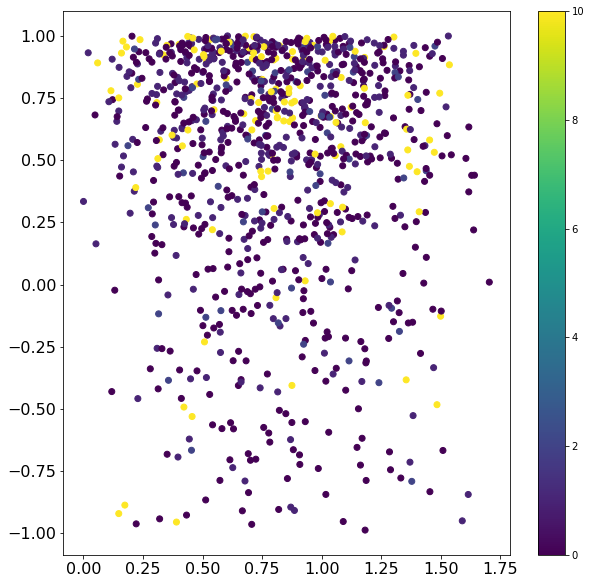

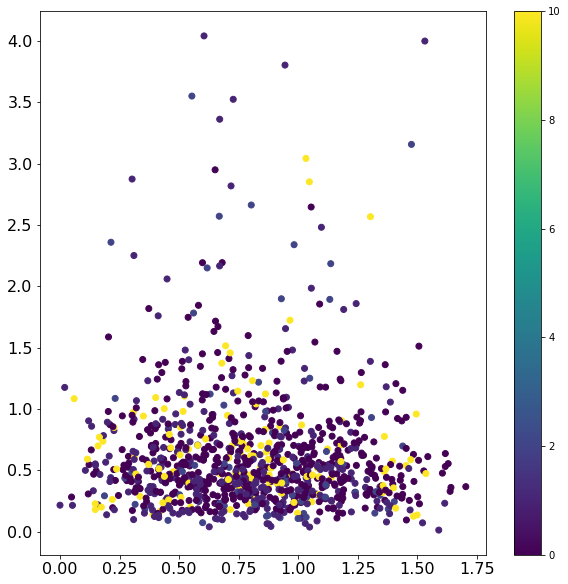

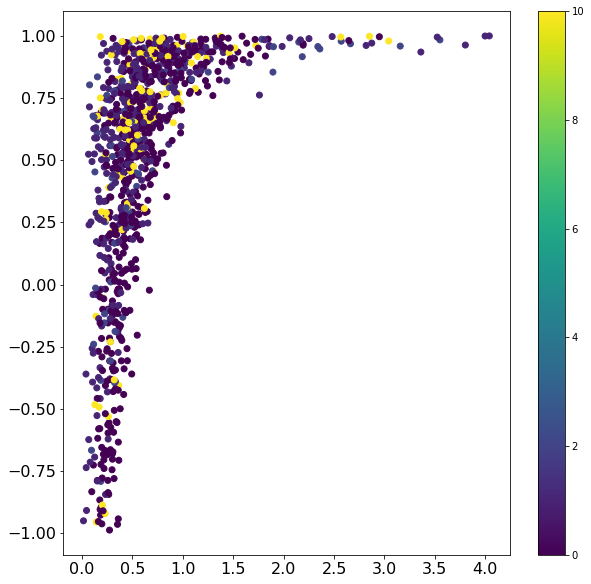

In [39]:
fig,ax = plt.subplots(figsize=(10,10))
im = ax.scatter(genie_muon.data.nu.prism_theta.values[:1000]
            ,genie_muon.data.costheta.values[:1000]
            ,c=genie_muon.data.nu.genie_mode.values[:1000]
            ,cmap='viridis')
fig.colorbar(im,ax=ax)
plotters.set_style(ax)

fig,ax = plt.subplots(figsize=(10,10))
im = ax.scatter(genie_muon.data.nu.prism_theta.values[:1000]
            ,genie_muon.data.genp.tot.values[:1000]
            ,c=genie_muon.data.nu.genie_mode.values[:1000]
            ,cmap='viridis')
fig.colorbar(im,ax=ax)
plotters.set_style(ax)

fig,ax = plt.subplots(figsize=(10,10))
im = ax.scatter(genie_muon.data.genp.tot.values[:1000]
            ,genie_muon.data.costheta.values[:1000]
            ,c=genie_muon.data.nu.genie_mode.values[:1000]
            ,cmap='viridis')
fig.colorbar(im,ax=ax)
plotters.set_style(ax)